# Final Project

### 獲取歷史資料

In [50]:
from finlab.data import Data

data = Data()

rev = data.get("當月營收")
close = data.get("收盤價")
open_ = data.get("開盤價")
high = data.get("最高價")
low = data.get("最低價")
vol = data.get("成交股數")

#財務指標
PB = data.get("股價淨值比")
pe = data.get("本益比")

rev.index = rev.index.shift(5, "d")

### 計算features

In [51]:
def bias(n):
    return close / close.rolling(n, min_periods=1).mean()

def acc(n):
    return close.shift(n) / (close.shift(2*n) + close) * 2

def rsv(n):
    l = close.rolling(n, min_periods=1).min()
    h = close.rolling(n, min_periods=1).max()
    
    return (close - l) / (h - l)

def mom(n):
    return (rev / rev.shift(1)).shift(n)

def yoy(n):
    return (rev / rev.shift(12)).shift(n)



features = {
    
    'PB':PB,
    'PE':pe,    
    
    'mom1': mom(1),
    'mom2': mom(2),
    'mom3': mom(3),
    'mom4': mom(4),
    'mom5': mom(5),
    'mom6': mom(6),
    'mom7': mom(7),
    'mom8': mom(8),
    'mom9': mom(9),
    
    'yoy': yoy(1),
    'delta_yoy':yoy(1)-yoy(2),
    
    'bias5': bias(5),
    'bias10': bias(10),
    'bias20': bias(20),
    'bias60': bias(60),
    'bias120': bias(120),
    'bias240': bias(240),
    
    'acc5': acc(5),
    'acc10': acc(10),
    'acc20': acc(20),
    'acc60': acc(60),
    'acc120': acc(120),
    'acc240': acc(240),
    
    'rsv5': rsv(5),
    'rsv10': rsv(10),
    'rsv20': rsv(20),
    'rsv60': rsv(60),
    'rsv120': rsv(120),
    'rsv240': rsv(240),
} 

In [52]:
list1=sorted(features)
list1

['PB',
 'PE',
 'acc10',
 'acc120',
 'acc20',
 'acc240',
 'acc5',
 'acc60',
 'bias10',
 'bias120',
 'bias20',
 'bias240',
 'bias5',
 'bias60',
 'delta_yoy',
 'mom1',
 'mom2',
 'mom3',
 'mom4',
 'mom5',
 'mom6',
 'mom7',
 'mom8',
 'mom9',
 'rsv10',
 'rsv120',
 'rsv20',
 'rsv240',
 'rsv5',
 'rsv60',
 'yoy']

### 製作dataset

##### 設定買賣頻率

In [53]:
every_month = rev.index
every_month

DatetimeIndex(['2005-02-15', '2005-03-15', '2005-04-15', '2005-05-15',
               '2005-06-15', '2005-07-15', '2005-08-15', '2005-09-15',
               '2005-10-15', '2005-11-15',
               ...
               '2022-01-15', '2022-02-15', '2022-03-15', '2022-04-15',
               '2022-05-15', '2022-06-15', '2022-07-15', '2022-08-15',
               '2022-09-15', '2022-10-15'],
              dtype='datetime64[ns]', name='date', length=213, freq=None)

##### 將dataframe 組裝起來

In [54]:
# features['bias20'].reindex(every_month, method='ffill')

for name, f in features.items():
    features[name] = f.reindex(every_month, method='ffill')

In [55]:

for name, f in features.items():
    features[name] = f.unstack()

In [56]:
import pandas as pd
dataset = pd.DataFrame(features)

In [57]:
feature_names = list(dataset.columns)

### 新增 label

In [58]:
from finlab import ml

ml.add_profit_prediction(dataset)
ml.add_rank_prediction(dataset)

### 刪除太大太小的歷史資料

In [59]:
print(dataset.shape)

def drop_extreme_case(dataset, feature_names, thresh=0.01):
    
    extreme_cases = pd.Series(False, index=dataset.index)
    for f in feature_names:
        tf = dataset[f]
        extreme_cases = extreme_cases | (tf < tf.quantile(thresh)) | (tf > tf.quantile(1-thresh))
    dataset = dataset[~extreme_cases]
    return dataset

dataset_drop_extreme_case = drop_extreme_case(dataset,list1, thresh=0.01)

print(dataset_drop_extreme_case.shape)

(433881, 33)
(375244, 33)


In [60]:
dataset_dropna = dataset_drop_extreme_case.dropna(how='any')
dataset_dropna = dataset_dropna.reset_index().set_index("date")

In [61]:
dataset_drop_extreme_case.index.get_level_values("date")

DatetimeIndex(['2005-02-15', '2005-03-15', '2005-04-15', '2005-05-15',
               '2005-06-15', '2005-07-15', '2005-08-15', '2005-09-15',
               '2005-10-15', '2005-11-15',
               ...
               '2021-09-15', '2021-11-15', '2021-12-15', '2022-02-15',
               '2022-03-15', '2022-04-15', '2022-06-15', '2022-08-15',
               '2022-09-15', '2022-10-15'],
              dtype='datetime64[ns]', name='date', length=375244, freq=None)

In [62]:
dataset_train = dataset_dropna.loc[:'2021']
dataset_test = dataset_dropna.loc['2022':]

### 神經網路模型

In [63]:
import os

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers

os.environ['KMP_DUPLICATE_LIB_OK']='True'

model = keras.models.Sequential()
model.add(layers.Dense(100, activation='relu',
                      input_shape=(len(feature_names),),
                      kernel_initializer=initializers.he_normal(seed=0)))
model.add(layers.Dense(100, activation='relu',
                      kernel_initializer=initializers.he_normal(seed=0)))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(1, activation='sigmoid'))


model.summary()

model.compile(loss='mean_squared_error',
              optimizer="adam",)

print('start fitting')
history = model.fit(dataset_train[feature_names], dataset_train['rank'],
                    batch_size=10000, #1000
                    epochs=3000, #225
                    verbose=1,
                    validation_split=0.1, )


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               3200      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 13,401
Trainable params: 13,401
Non-trainable params: 0
_________________________________________________________________
start fitting
Epoch 1/3000
12/12 [==============================] - ETA: 0s - loss: 0.270 - ETA: 0s - loss: 0.271 - ETA: 0s - loss: 0.269 - ETA: 0s - loss: 0.267 - ETA: 0s - loss: 0.265 - ETA: 0s - loss: 0.263 - 1s 56ms/step - loss: 0.2629 - val_lo

### 結果

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['val_loss'][1:])
plt.plot(history.history['loss'][1:])

### lightgbm Model

In [ ]:
import lightgbm as lgb
cf = lgb.LGBMRegressor(n_estimators=500)
cf.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

### Random Forest Model

In [67]:
from sklearn.ensemble import RandomForestRegressor

cf2 = RandomForestRegressor(n_estimators=100)
cf2.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

RandomForestRegressor()

<AxesSubplot:xlabel='Value', ylabel='Feature'>

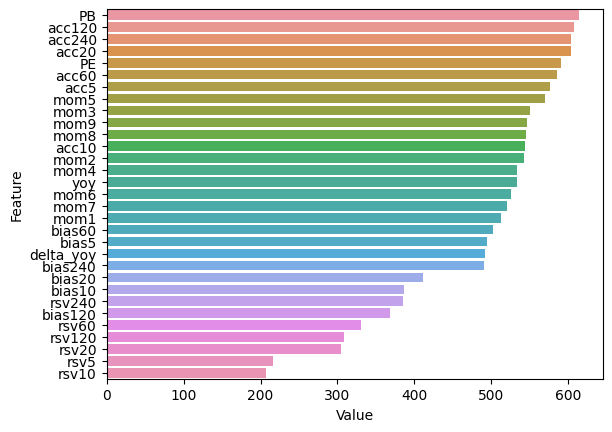

In [68]:
feature_imp = pd.DataFrame(zip(cf.feature_importances_, feature_names), 
                           columns=['Value','Feature']).sort_values('Value', ascending=False)
feature_imp

%matplotlib inline
import seaborn as sns
sns.barplot(x="Value", y="Feature", data=feature_imp)

### Ensemble learning

In [69]:
dataset_drop = dataset.dropna(subset=feature_names+['return'])

vals = model.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result1'] = pd.Series(vals.swapaxes(0,1)[0], dataset_drop.index)

vals = cf.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result2'] = pd.Series(vals, dataset_drop.index)

vals = cf2.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result3'] = pd.Series(vals, dataset_drop.index)

dataset_drop = dataset_drop.reset_index().set_index("date")

D:\ProgramData\Miniconda3\envs\finlab\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\ProgramData\Miniconda3\envs\finlab\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
D:\ProgramData\Miniconda3\envs\finlab\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

# backtest

<AxesSubplot:xlabel='date'>

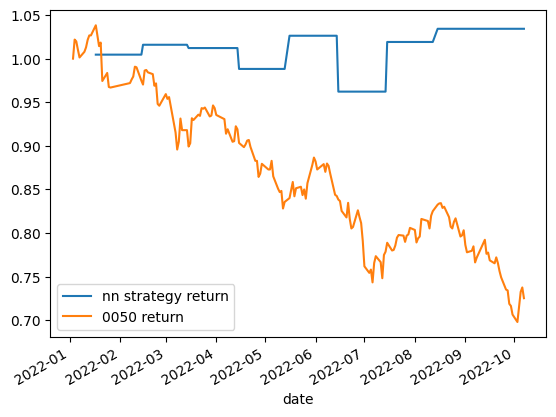

In [74]:
import math


dates = sorted(list(set(dataset_drop.index)))

rs = []
for d in dates:
    
    dataset_time = dataset_drop.loc[d]
    
    dataset_time = drop_extreme_case(dataset_time,list1, thresh=0.01)
    
    rank = dataset_time['result1'] + dataset_time['result2'] + dataset_time['result3'] 
    
    condition = (rank >= rank.nlargest(20).iloc[-1]) 
    r = dataset_time['return'][condition].mean()

    rs.append(r * (1-3/1000-1.425/1000*2*0.6))

rs = pd.Series(rs, index=dates)['2022':].cumprod()

s0050 = close['0050']['2022':]

pd.DataFrame({'nn strategy return':rs.reindex(s0050.index, method='ffill'), '0050 return':s0050/s0050[0]}).plot()



### 當月持股狀況

In [75]:
dataset.index.levels[1]

DatetimeIndex(['2005-02-15', '2005-03-15', '2005-04-15', '2005-05-15',
               '2005-06-15', '2005-07-15', '2005-08-15', '2005-09-15',
               '2005-10-15', '2005-11-15',
               ...
               '2022-01-15', '2022-02-15', '2022-03-15', '2022-04-15',
               '2022-05-15', '2022-06-15', '2022-07-15', '2022-08-15',
               '2022-09-15', '2022-10-15'],
              dtype='datetime64[ns]', name='date', length=213, freq=None)

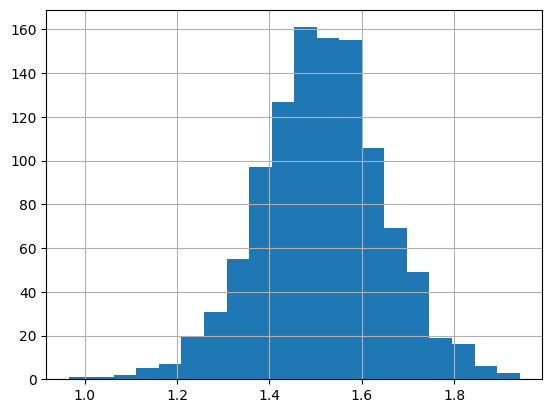

In [76]:
# get the latest dataset
last_date = "2022-09-15"#dataset.index.levels[1].max()
is_last_date = dataset.index.get_level_values('date') == last_date
last_dataset = dataset[is_last_date].copy()


last_dataset = drop_extreme_case(last_dataset,list1, thresh=0.01)


# remove NaN testcases
last_dataset = last_dataset.dropna(subset=feature_names)

# predict

vals = model.predict(last_dataset[feature_names].astype(float))
last_dataset['result1'] = pd.Series(vals.swapaxes(0,1)[0], last_dataset.index)

vals = cf.predict(last_dataset[feature_names].astype(float))
last_dataset['result2'] = pd.Series(vals, last_dataset.index)

vals = cf2.predict(last_dataset[feature_names].astype(float))
last_dataset['result3'] = pd.Series(vals, last_dataset.index)

# calculate score

rank = last_dataset['result1'] + last_dataset['result2'] + last_dataset['result3']
condition = (rank >= rank.nlargest(20).iloc[-1]) 

# plot rank distribution
rank.hist(bins=20)


# show the best 20 stocks
slist1 = rank[condition].reset_index()['stock_id']

# 平均分配資產於股票之中

In [77]:
close = data.get("收盤價")

money = 50000*3
stock_prices = close[rank[condition].reset_index()['stock_id']].iloc[-1]


print("股票平分張數:")
money / len(stock_prices) / stock_prices / 1000


股票平分張數:


stock_id
2206    0.189633
2358    0.506757
2421    0.192802
2471    0.282486
2637    0.127334
2643    0.109012
3231    0.279851
3501    0.160428
3611    0.040107
3679    0.088757
3704         NaN
4417    0.206044
4506    0.101488
4958    0.068807
5403    0.109810
5493    0.141777
6139    0.246711
6184    0.155763
8342    0.138376
9924    0.182260
Name: 2022-10-07 00:00:00, dtype: float64